<a href="https://colab.research.google.com/github/tanmayg/LS/blob/master/StackOverflow_Post.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
tf.__version__

'2.2.0-rc2'

In [0]:
import tensorflow as tf

In [0]:
PROJECT_ID = "<YOUR PROJECT ID>"

In [5]:
import sys, os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# If you are running this notebook in Colab, follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()
  !pip install witwidget --quiet
  !gcloud config set project $PROJECT_ID

elif "DL_PATH" in os.environ:
  !sudo pip install tabulate --quiet

     |████████████████████████████████| 2.3MB 2.7MB/s 
     |████████████████████████████████| 1.1MB 22.7MB/s 
Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey



In [13]:
# Copy the data to your notebook instance
!gsutil cp 'gs://lsattentionmodelbucket/data_sample.csv' .

Copying gs://lsattentionmodelbucket/data_sample.csv...
/ [1 files][554.9 KiB/554.9 KiB]                                                
Operation completed over 1 objects/554.9 KiB.                                    


In [0]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import sequence
import pandas as pd
import numpy as np

def preprocess_data(datafile, batch_size, maxlen, scaler=None):
    """ Preprocessing data and getting a sequence of word indices """
    df = pd.read_csv(datafile)
    ID = list(set(list(df.data_Id)))
    mf = (len(ID)//batch_size)*batch_size
    ID = ID[:mf]
    print("Unique ID count:", len(ID))
    df = df.set_index(['data_Id', 'feat_1'])
    df = df.iloc[df.index.get_level_values('data_Id').isin(ID)]
    
    #create the input & output sets for train data
    data_X = df.drop(['out_y1', 'out_y2', 'out_y3'],axis=1)

    #define StdScaler Scaler for input variables
    if scaler is None:
        scaler = StandardScaler()
        scaler = scaler.fit(data_X[data_X.columns])
        
    data_X[data_X.columns] = scaler.transform(data_X[data_X.columns])
    
    #define output labels
    data_Y = df[['out_y1', 'out_y2', 'out_y3']]
    data_Y = data_Y.astype(int)  

    #get the feature names
    feature_X = np.array(data_X.columns)
    feature_Y = np.array(data_Y.columns)
    
    # train data #
    data_X = [data_X.loc[patient].values for patient in ID]
    data_Y = [data_Y.loc[patient].values for patient in ID]
    
    data_X = sequence.pad_sequences(data_X, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
    data_Y = sequence.pad_sequences(data_Y, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

    #change any NAs to zero
    data_X = np.nan_to_num(data_X)
    
    return(ID, data_X, data_Y, feature_X, feature_Y, scaler)

In [17]:
batch_size=128
maxlen=5
data_ID, data_X, data_Y, feature_X, feature_Y, scaler = preprocess_data('data_sample.csv', 
                                                       batch_size=batch_size, maxlen=maxlen, scaler=None)

Unique ID count: 1152


In [18]:
data_X.shape

(1152, 5, 20)

In [0]:
data_X = np.nan_to_num(data_X)

In [0]:
input_layer = tf.keras.layers.Input(data_X.shape[-2:])
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, stateful=False))(input_layer)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, stateful=False))(x)
output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(data_Y.shape[-1], activation='sigmoid'), name='output')(x)

In [0]:
model = tf.keras.Model(outputs=output, inputs=input_layer)

In [23]:
optimizer = tf.keras.optimizers.SGD(lr=0.0002)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 20)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 5, 64)             13568     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 5, 64)             24832     
_________________________________________________________________
output (TimeDistributed)     (None, 5, 3)              195       
Total params: 38,595
Trainable params: 38,595
Non-trainable params: 0
_________________________________________________________________


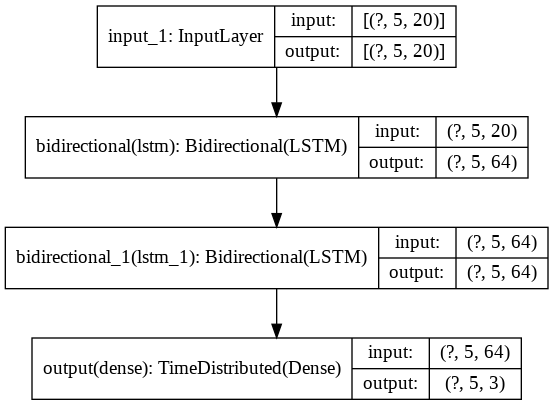

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [25]:
model.fit(data_X, data_Y, batch_size=batch_size, shuffle=False, epochs=5, verbose=1)

Epoch 1/5
9/9 [==============================] - 0s 11ms/step - loss: 0.6944 - accuracy: 0.2372
Epoch 2/5
9/9 [==============================] - 0s 10ms/step - loss: 0.6942 - accuracy: 0.2378
Epoch 3/5
9/9 [==============================] - 0s 10ms/step - loss: 0.6940 - accuracy: 0.2380
Epoch 4/5
9/9 [==============================] - 0s 9ms/step - loss: 0.6938 - accuracy: 0.2382
Epoch 5/5
9/9 [==============================] - 0s 10ms/step - loss: 0.6936 - accuracy: 0.2385


In [26]:
## Convert our Keras model to an estimator
keras_estimator = tf.keras.estimator.model_to_estimator(keras_model=model, model_dir='export')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Using config: {'_model_dir': 'export', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1

In [0]:
# We need this serving input function to export our model in the next cell
serving_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(
    {'input_1': model.input}
)

In [0]:
BUCKET_NAME = "<YOUR BUCKET NAME>"
REGION = "us-central1"

In [29]:
export_path = keras_estimator.export_saved_model(
  'gs://' + BUCKET_NAME + '/explanations',
  serving_input_receiver_fn=serving_fn
).decode('utf-8')
print(export_path)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from export/keras/keras_model.ckpt
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: gs://lsattentionmodelbucket/explanations/temp-1586089894/saved_model.pb
gs://lsattentionmodelbucket/explanations/1586089894


In [30]:
!saved_model_cli show --dir $export_path --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 5, 20)
        name: input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 5, 3)
        name: output/Reshape_1:0
  Method name is: tensorflow/serving/predict


In [0]:
#Get the input_tensor_name & output_tensor_name from the command "!saved_model_cli show --dir $export_path --all" ran above.
explanation_metadata = {
    "inputs": {
      "data": {
        "input_tensor_name": "input_1:0",
        "input_baselines": [np.mean(data_X, axis=0).tolist()],
        "encoding": "bag_of_features", 
        "index_feature_mapping": feature_X.tolist()
      }
    },
    "outputs": {
      "duration": {
        "output_tensor_name": "output/Reshape_1:0"
      }
    },
  "framework": "tensorflow"
  }

In [0]:
import json
# Write the json to a local file
with open('explanation_metadata.json', 'w') as output_file:
  json.dump(explanation_metadata, output_file)

In [33]:
!gsutil cp explanation_metadata.json $export_path

Copying file://explanation_metadata.json [Content-Type=application/json]...
/ [1 files][  2.5 KiB/  2.5 KiB]                                                
Operation completed over 1 objects/2.5 KiB.                                      


In [0]:
MODEL = 'sample_model'

In [35]:
# Create the model if it doesn't exist yet (you only need to run this once)
!gcloud ai-platform models create $MODEL --enable-logging --regions=us-central1

Created ml engine model [projects/lucid-sonar-139519/models/sample_model].


In [0]:
# Each time you create a version the name should be unique
VERSION = 'v1'

In [0]:
# Create the version with gcloud
explain_method = 'integrated-gradients'
!gcloud beta ai-platform versions create $VERSION \
--model $MODEL \
--origin $export_path \
--runtime-version 1.15 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method $explain_method \
--num-integral-steps 25

In [0]:
# Make sure the model deployed correctly. State should be `READY` in the following log
!gcloud ai-platform versions describe $VERSION --model $MODEL

createTime: '2020-04-05T05:44:40Z'
deploymentUri: gs://lsattentionmodelbucket/explanations/1586065104
etag: 0yiSej983oo=
explanationConfig:
  integratedGradientsAttribution:
    numIntegralSteps: 25
framework: TENSORFLOW
isDefault: true
machineType: n1-standard-4
name: projects/lucid-sonar-139519/models/diag_pred_explain_stateless_0504/versions/v1
pythonVersion: '3.7'
runtimeVersion: '1.15'
state: READY


In [0]:
# Format data for prediction to our model
prediction_json = {'input_1': data_X[:5].tolist()}
with open('diag-data.json', 'w') as outfile:
  json.dump(prediction_json, outfile)

In [0]:
!gcloud beta ai-platform explain --model $MODEL --json-instances='diag-data.json'

{
  "error": "Explainability failed with exception: <_InactiveRpcError of RPC that terminated with:\n\tstatus = StatusCode.INVALID_ARGUMENT\n\tdetails = \"transpose expects a vector of size 4. But input(1) is a vector of size 3\n\t [[{{node bidirectional/forward_lstm_1/transpose}}]]\"\n\tdebug_error_string = \"{\"created\":\"@1586068796.692241013\",\"description\":\"Error received from peer ipv4:10.7.252.78:8500\",\"file\":\"src/core/lib/surface/call.cc\",\"file_line\":1056,\"grpc_message\":\"transpose expects a vector of size 4. But input(1) is a vector of size 3\\n\\t [[{{node bidirectional/forward_lstm_1/transpose}}]]\",\"grpc_status\":3}\"\n>"
}


In [0]:
!gcloud ai-platform predict --model $MODEL --version $VERSION --json-instances='diag-data.txt'

In [0]:
resp_obj = !gcloud beta ai-platform explain --model $MODEL --version $VERSION --json-instances='diag-data.txt'
response = json.loads(resp_obj.s)

In [0]:
explanations = response['explanations'][0]['attributions_by_label'][0]

In [0]:
# Prepare 10 test examples to our model for prediction
for i in range(10):
  with open('diag-data-10.txt', 'a') as outfile:
    json.dump({'input_1': ts_in_seq[i].tolist()}, outfile)
    outfile.write('\n')

In [0]:
# Make the request with gcloud
batch_explain = !gcloud beta ai-platform explain --model $MODEL --version $VERSION --json-instances='diag-data-10.txt'
attributions_resp = json.loads(batch_explain.s)

In [0]:
# This is the number of data points we'll send to the What-if Tool
WHAT_IF_TOOL_SIZE = 100

from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

def create_list(ex_dict):
  new_list = []
  for i in feature_names:
    new_list.append(ex_dict[i])
  return new_list

def example_dict_to_input(example_dict):
  return { 'input_1': create_list(example_dict) }